**Cale Kochenour** \
GEOG 489 Spring 2020 \
March 15, 2020

# Extracting and Analyzing GPX Data from the Mount Mansfield Double Up

## 1.0 Problem

## 2.0 Background

## 3.0 Assumptions

## 4.0 Techniques and Tools

### 4.1 Techniques

### 4.2 Tools

## 5.0 Solution

### 5.1 Package Imports

In [1]:
# Standard library imports
import os
import re
from datetime import datetime

# Commonly used packages
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import pandas as pd
from pandas.plotting import register_matplotlib_converters

# Third party imports
import geopandas as gpd
import gpxpy

### 5.2 Function Definitions

In [2]:
def extract_gpx_data(gpx_file_path, attribute='elevation'):
    """Reads in a GPX file and returns a list of values
    for a specified GPX attribute.
    
    Parameters
    ----------
    gpx_file_path : str
        File path to the GPX file (.gpx extension).
        
    attribute: str
        Name of the attribute to extract. Default
        value is 'elevation'. Must match one of the
        entries in the function-defined list.
    
    Returns
    -------
    data : list
        List containing float values of the extracted
        GPX attributes.
    """   
    # Open GPX file in context manager and parse with gpxpy
    with open(gpx_file_path) as gpx_file:
        gpx = gpxpy.parse(gpx_file)

    # Define GPX main attributes
    primary_attributes = [
        "latitude", 
        "longitude",
        "elevation",
        "time"   
    ]
    
    # Define GPX extension attributes
    secondary_attributes = [
        "cadence", "distance", "altitude",
        "energy", "speed", "verticalSpeed"
    ]
    
    # Check if specified attribute is in main 
    #  GPX attributes (lat/lon/elevation/time)
    if attribute in primary_attributes: 
            
        # Create list of values for attribute
        data = [{
            "latitude": point.latitude, 
            "longitude": point.longitude, 
            "elevation": point.elevation, 
            "time": point.time
            }.get(attribute)
            for track in gpx.tracks
            for segment in track.segments
            for point in segment.points
        ]
            
        print(f"SUCCESS: Added {attribute} data to dictionary.")
        
    # Check if specified attribute is in
    #  GPX extensions (cadence/distance/altitude
    #  /energy/speed/verticalSpeed)
    elif attribute in secondary_attributes:

        # Define pattern for attribute to match on
        pattern = re.compile(f"^.*{attribute}.*$")

        # Create list of values for attribute
        data = [
            float(extension.text) 
            for track in gpx.tracks 
            for segment in track.segments 
            for point in segment.points 
            for extension in point.extensions 
            if pattern.match(extension.tag)
        ]
        
        print(f"SUCCESS: Added {attribute} data to dictionary.")
        
    else:   
        data = []
        print("Invalid attribute. Must be one of the following: "
              "latitude, longitude, elevation, time, cadence "
              "distance, altitude, energy, speed, verticalSpeed.")
            
    # List of attribute values
    return data

### 5.3 Environment Setup/User Input

In [3]:
# Define and set working directory
working_directory = os.path.join(
    "C:\\", "PSU", "03-geog489-advanced-python-programming-gis", "lesson-05")

os.chdir(working_directory)

# Define relative path to GPX file and zipped shapefile
double_up_gpx_path = os.path.join(
    "02-raw-data", "mansfield-double-up-course.gpx")

double_up_shp_path = os.path.join(
    "02-raw-data", "mount_mansfield_double_up_course.zip")

In [4]:
# Datetime converters; matplotlib/pandas
register_matplotlib_converters()

### 5.4 GPX Data Extraction

In [5]:
# Define list of GPX attributes
attribute_list = [
    "latitude", "longitude", "elevation", "time",
    "cadence", "distance", "altitude", "energy", 
    "speed", "verticalSpeed"
]

# Create dataframe from dictionary of gpx data
double_up_gpx_df = pd.DataFrame({
    attribute: extract_gpx_data(double_up_gpx_path, attribute)
    for attribute in attribute_list
})

SUCCESS: Added latitude data to dictionary.
SUCCESS: Added longitude data to dictionary.
SUCCESS: Added elevation data to dictionary.
SUCCESS: Added time data to dictionary.
SUCCESS: Added cadence data to dictionary.
SUCCESS: Added distance data to dictionary.
SUCCESS: Added altitude data to dictionary.
SUCCESS: Added energy data to dictionary.
SUCCESS: Added speed data to dictionary.
SUCCESS: Added verticalSpeed data to dictionary.


In [6]:
# Optional; view dataframe of raw GPX data
##double_up_gpx_df

### 5.5 GPX Data Processing

In [7]:
# Create copy of dataframe to modify/enhance
double_up_df_enhance = double_up_gpx_df.copy()

# Add elevation in feet
double_up_df_enhance["elevation_ft"] = double_up_df_enhance.elevation.apply(
    lambda x: x * 3.28084)

# Convert dateime object to plotable format (remove timezone)
double_up_df_enhance.time = double_up_df_enhance.time.apply(
    lambda x: datetime.strptime(str(x).replace('+00:00', ''), '%Y-%m-%d %H:%M:%S'))

# Change time to US Eastern, subtract 4 from timestamp hour
double_up_df_enhance.time = double_up_df_enhance.time.apply(
    lambda x: x.replace(hour=x.hour-4))

# Add distance in miles
double_up_df_enhance["distance_mile"] = double_up_df_enhance.distance.apply(
    lambda x: x / 1609.344)

# Drop altitude column (copy of elevation)
double_up_df_enhance.drop(columns='altitude', inplace=True)

# Normalize energy (units unknown)
double_up_df_enhance["energy_norm"] = double_up_df_enhance.energy.apply(
    lambda x: x / double_up_df_enhance.energy.max())

# Add speed in miles per hour
double_up_df_enhance["speed_mph"] = double_up_df_enhance.speed.apply(
    lambda x: x * 2.236936)

# Add vertical speed in ft/second
double_up_df_enhance["vertical_speed_ft_per_sec"] = double_up_df_enhance.verticalSpeed.apply(
    lambda x: x * 3.28084)

In [8]:
# Optional; view modified dataframe
##double_up_df_enhance

In [9]:
# Create dataframes for UP (vertical speed >= 0) 
#  and DOWN (vertical speed < 0); for plotting purposes
vertical_up_df = double_up_df_enhance[
    double_up_df_enhance.vertical_speed_ft_per_sec >= 0]

vertical_down_df = double_up_df_enhance[
    double_up_df_enhance.vertical_speed_ft_per_sec < 0]

In [10]:
# Optional; view up/down dataframes
##vertical_up_df 
##vertical_down_df 

In [11]:
# Create geodataframe from dataframe
crs = {'init': 'epsg:4326'}
double_up_gdf = gpd.GeoDataFrame(
    double_up_df_enhance, 
    geometry=gpd.points_from_xy(
        double_up_df_enhance.longitude, 
        double_up_df_enhance.latitude)
)

# Drop latitude/longitude (redundant with geometry)
double_up_gdf.drop(columns=["latitude", "longitude"], inplace=True)

In [12]:
# Optional; view geodataframe
##double_up_gdf

### 5.6 GPX Data Visualization

#### 5.6.1 Data Attribute Plots

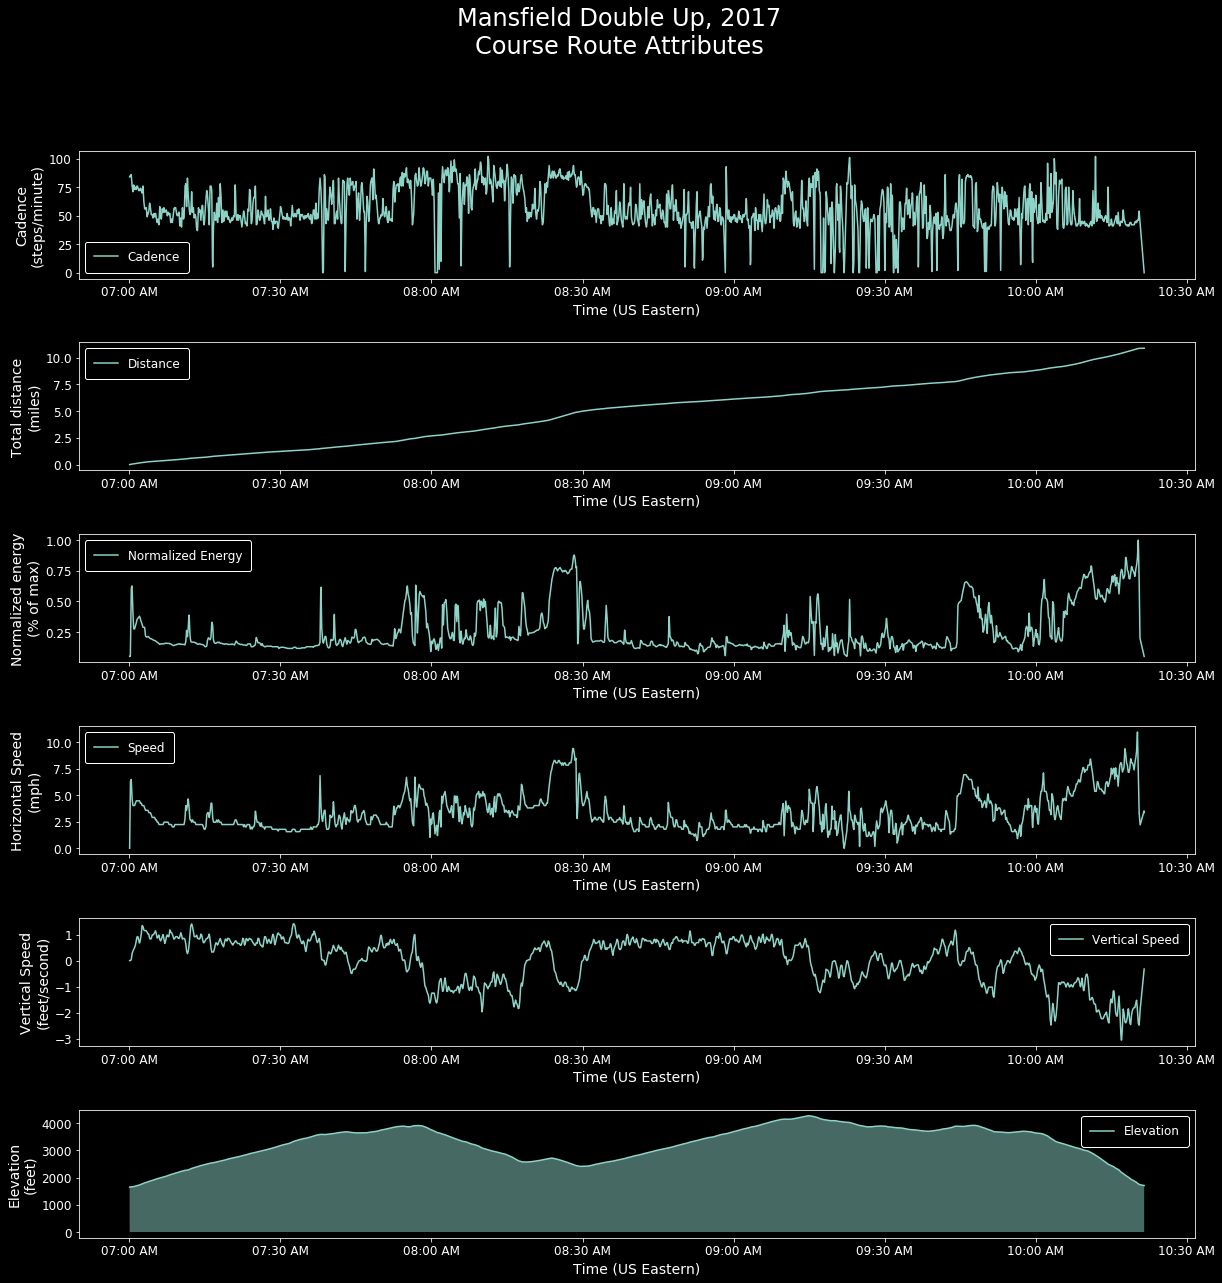

In [13]:
# Plot all raw data attributes over time
with plt.style.context('dark_background'): 

    fig, ax = plt.subplots(6, 1, figsize=(20, 20))#, sharex=True)
    
    plt.suptitle("Mansfield Double Up, 2017\nCourse Route Attributes", size=24)
    
    plt.subplots_adjust(hspace=0.5)

    ax[0].plot(double_up_df_enhance.time, double_up_df_enhance.cadence,
               label='Cadence', lw=1.5)

    ax[1].plot(double_up_df_enhance.time, double_up_df_enhance.distance_mile,
               label='Distance', lw=1.5)

    ax[2].plot(double_up_df_enhance.time, double_up_df_enhance.energy_norm,
               label='Normalized Energy', lw=1.5)

    ax[3].plot(double_up_df_enhance.time, double_up_df_enhance.speed_mph,
               label='Speed', lw=1.5)

    ax[4].plot(double_up_df_enhance.time, double_up_df_enhance.vertical_speed_ft_per_sec,
               label='Vertical Speed', lw=1.5, zorder=2)
    #ax[4].axhline(y=0, color='w', lw=1.5, zorder=1)#, #alpha=0.5)

    ax[5].plot(double_up_df_enhance.time, double_up_df_enhance.elevation_ft,
               label='Elevation', lw=1.5)
    ax[5].fill_between(double_up_df_enhance.time, double_up_df_enhance.elevation_ft, alpha=0.5)
   
    # Define the date format
    date_form = DateFormatter("%H:%M AM")
    #ax[0].xaxis.set_major_formatter(date_form)

    ax[0].set_ylabel("Cadence\n(steps/minute)")
    ax[1].set_ylabel("Total distance\n(miles)")
    ax[2].set_ylabel("Normalized energy\n(% of max)")
    ax[3].set_ylabel("Horizontal Speed\n(mph)")
    ax[4].set_ylabel("Vertical Speed\n(feet/second)")
    ax[5].set_ylabel("Elevation\n(feet)")
    
    for axes in ax:
        axes.xaxis.set_major_formatter(date_form)
        axes.legend(loc='best', 
                    borderpad=0.75,
                    edgecolor='white',
                    fontsize=12,
                    shadow=True)
        axes.xaxis.label.set_size(14)
        axes.yaxis.label.set_size(14)
        axes.title.set_size(24)
        axes.tick_params(labelsize=12)
        axes.set_xlabel("Time (US Eastern)")

    plt.show()

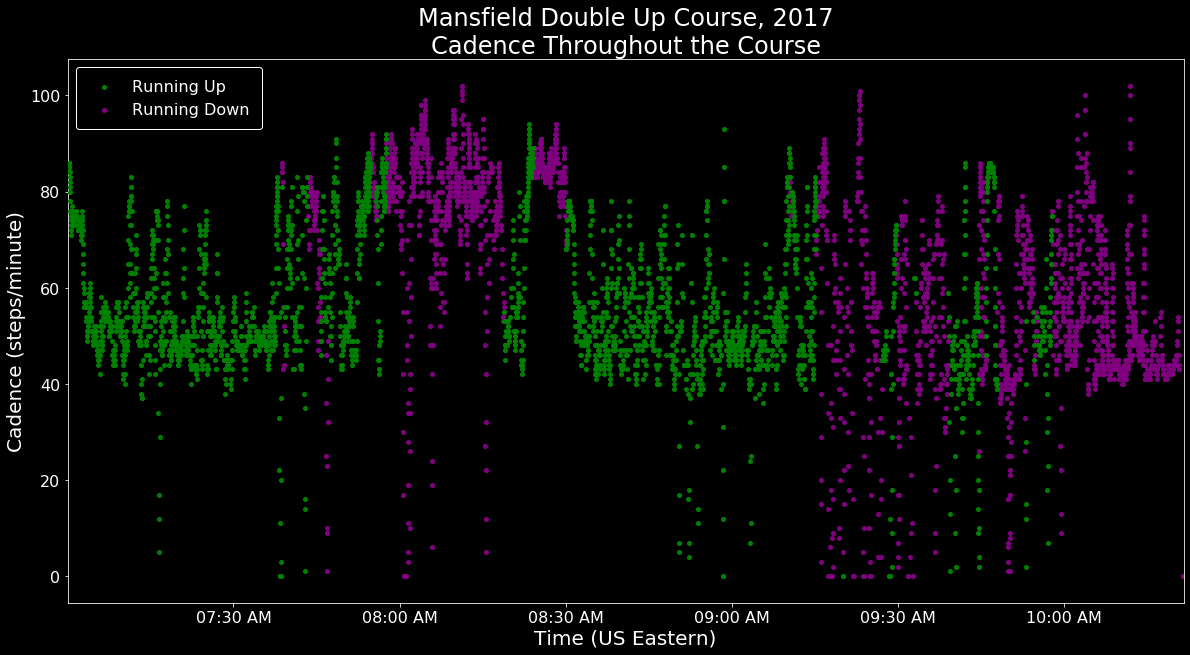

In [14]:
# Plot cadence, distinguishing up/down movement
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.scatter(
        vertical_up_df.time, vertical_up_df.cadence, color='green',
        label='Running Up', zorder=3, s=16)#, linewidth=2)
    ax.scatter(
        vertical_down_df.time, vertical_down_df.cadence, color='purple', 
        label='Running Down', zorder=2, s=16)

    plt.xlim(double_up_df_enhance.time.min(), double_up_df_enhance.time.max())


    ax.set_xlabel("Time (US Eastern)")
    #ax.xaxis.label.set_size(12)
    ax.set_ylabel("Cadence (steps/minute)")
    #ax.yaxis.label.set_size(12)
    ax.set_title("Mansfield Double Up Course, 2017\nCadence Throughout the Course", size=20)

    #ax.grid(True, zorder=1)

    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.title.set_size(24)
    ax.tick_params(labelsize=16)

    ax.legend(borderpad=0.75,
          edgecolor='white',
          fontsize=16,
          shadow=True)
    
    # Define the date format
    date_form = DateFormatter("%H:%M AM")
    ax.xaxis.set_major_formatter(date_form)

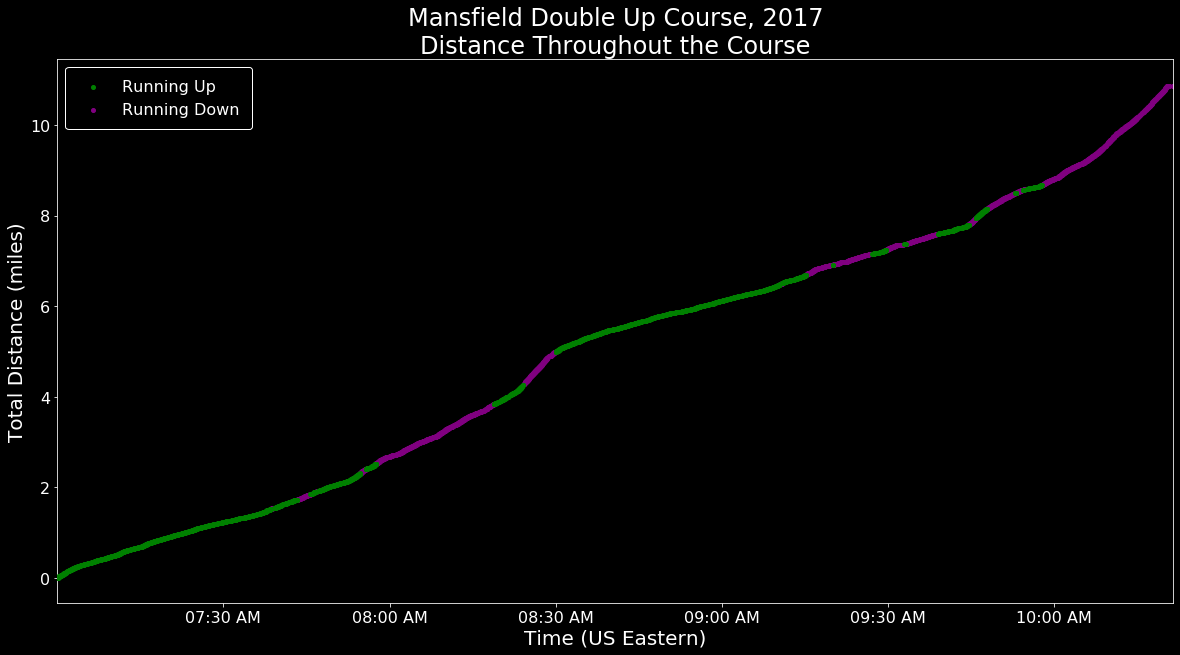

In [15]:
# Plot accumulated distance, distinguishing up/down movement
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.scatter(
        vertical_up_df.time, vertical_up_df.distance_mile, color='green',
        label='Running Up', zorder=3, s=16)#, linewidth=2)
    ax.scatter(
        vertical_down_df.time, vertical_down_df.distance_mile, color='purple', 
        label='Running Down', zorder=2, s=16)

    plt.xlim(double_up_df_enhance.time.min(), double_up_df_enhance.time.max())
    
    ax.set_xlabel("Time (US Eastern)")
    #ax.xaxis.label.set_size(12)
    ax.set_ylabel("Total Distance (miles)")
    #ax.yaxis.label.set_size(12)
    ax.set_title("Mansfield Double Up Course, 2017\nDistance Throughout the Course", size=20)

    #ax.grid(True, zorder=1)

    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.title.set_size(24)
    ax.tick_params(labelsize=16)

    ax.legend(borderpad=0.75,
          edgecolor='white',
          fontsize=16,
          shadow=True)
    
    # Define the date format
    date_form = DateFormatter("%H:%M AM")
    ax.xaxis.set_major_formatter(date_form)

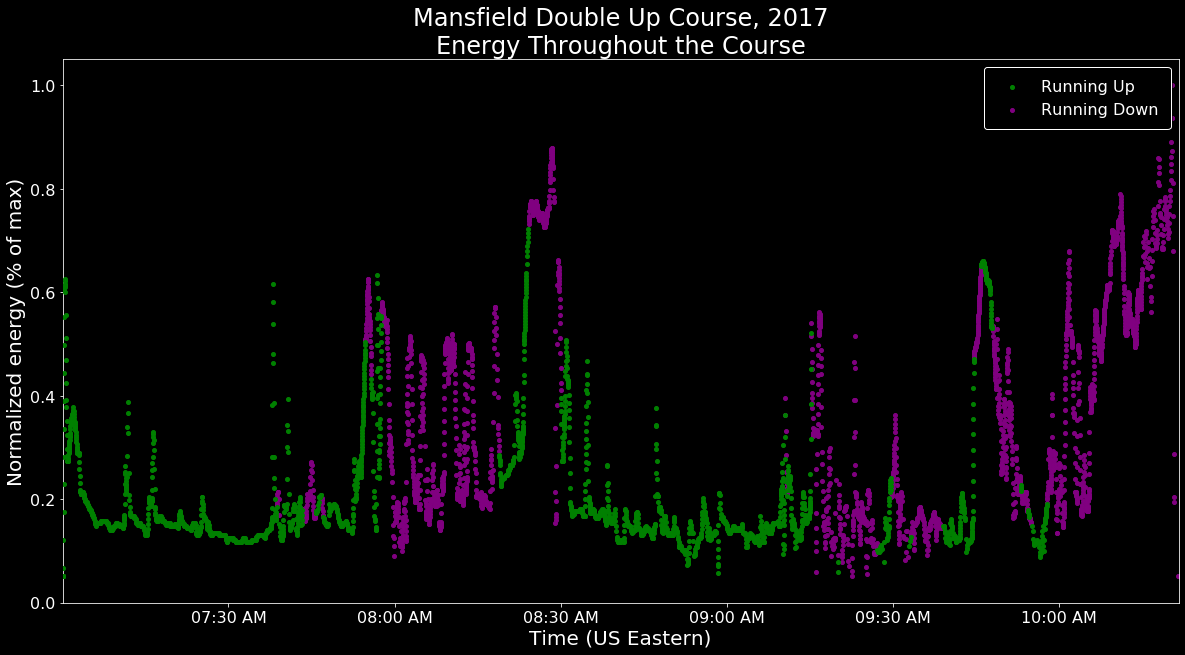

In [16]:
# Plot normalized energry, distinguishing up/down movement
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.scatter(
        vertical_up_df.time, vertical_up_df.energy_norm, color='green',
        label='Running Up', zorder=3, s=16)#, linewidth=2)
    ax.scatter(
        vertical_down_df.time, vertical_down_df.energy_norm, color='purple', 
        label='Running Down', zorder=2, s=16)

    plt.xlim(double_up_df_enhance.time.min(), double_up_df_enhance.time.max())
    
    ax.set_xlabel("Time (US Eastern)")
    #ax.xaxis.label.set_size(12)
    ax.set_ylabel("Normalized energy (% of max)")
    #ax.yaxis.label.set_size(12)
    ax.set_title("Mansfield Double Up Course, 2017\nEnergy Throughout the Course", size=20)

    #ax.grid(True, zorder=1)

    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.title.set_size(24)
    ax.tick_params(labelsize=16)

    ax.legend(borderpad=0.75,
          edgecolor='white',
          fontsize=16,
          shadow=True)
    
    # Define the date format
    date_form = DateFormatter("%H:%M AM")
    ax.xaxis.set_major_formatter(date_form)

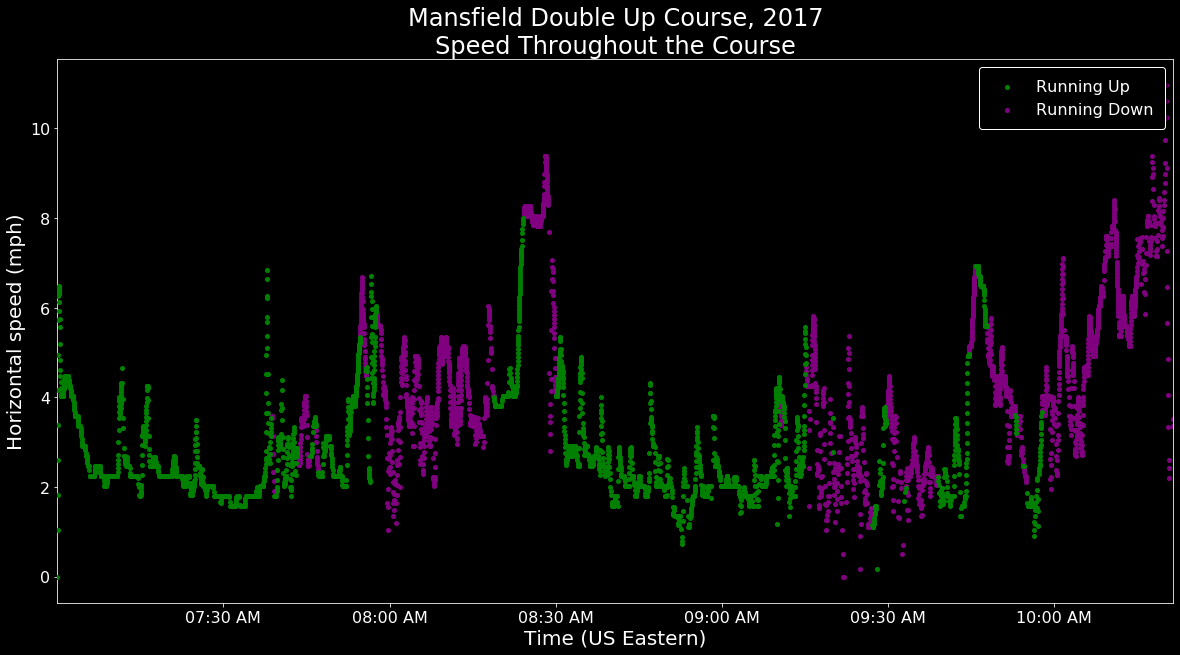

In [17]:
# Plot horizontal speed, distinguishing up/down movement
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.scatter(
        vertical_up_df.time, vertical_up_df.speed_mph, color='green',
        label='Running Up', zorder=3, s=16)#, linewidth=2)
    ax.scatter(
        vertical_down_df.time, vertical_down_df.speed_mph, color='purple', 
        label='Running Down', zorder=2, s=16)

    plt.xlim(double_up_df_enhance.time.min(), double_up_df_enhance.time.max())

    
    ax.set_xlabel("Time (US Eastern)")
    #ax.xaxis.label.set_size(12)
    ax.set_ylabel("Horizontal speed (mph)")
    #ax.yaxis.label.set_size(12)
    ax.set_title("Mansfield Double Up Course, 2017\nSpeed Throughout the Course", size=20)

    #ax.grid(True, zorder=1)

    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.title.set_size(24)
    ax.tick_params(labelsize=16)

    ax.legend(borderpad=0.75,
          edgecolor='white',
          fontsize=16,
          shadow=True)
    
    # Define the date format
    date_form = DateFormatter("%H:%M AM")
    ax.xaxis.set_major_formatter(date_form)

#### 5.6.2 Course Plots

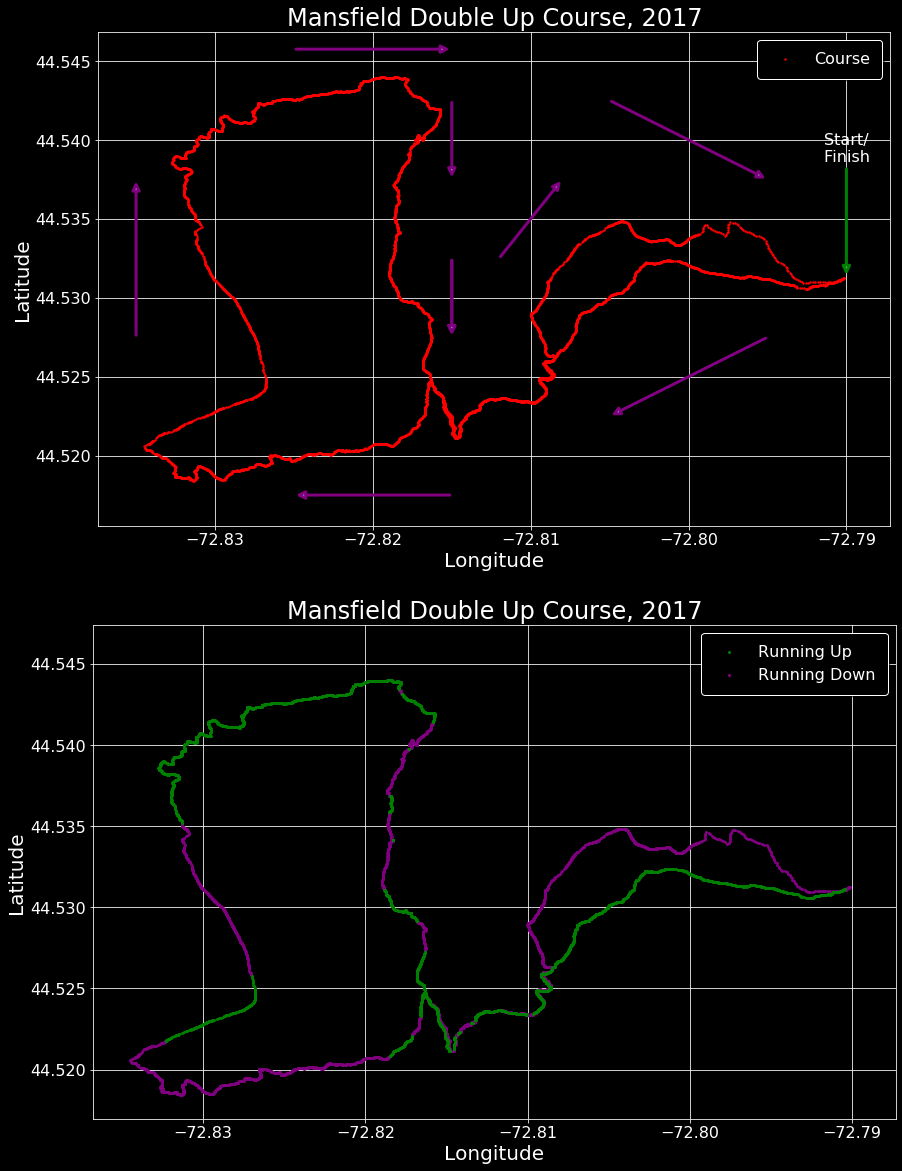

In [18]:
 # Plot course lat/lon and distinguish up/down
with plt.style.context('dark_background'):   
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))

    double_up_gdf.plot(ax=ax1, markersize=2, color='r', zorder=2, label='Course')  #style_kwds={'linewidth': 2})

    ax1.set_xlabel("Longitude")
    #ax.xaxis.label.set_size(12)
    ax1.set_ylabel("Latitude")
    #ax.yaxis.label.set_size(12)
    ax1.set_title("Mansfield Double Up Course, 2017", size=20)

    ax1.grid(True, zorder=1)

    ax1.xaxis.label.set_size(20)
    ax1.yaxis.label.set_size(20)
    ax1.title.set_size(24)
    ax1.tick_params(labelsize=16)
    
    ax1.legend(borderpad=0.75,
          edgecolor='white',
          fontsize=16,
          shadow=True)

    #     ax.annotate(s='Start/Finish',

    #             arrowprops={'arrowstyle': '-|>'},
    #             ha='center', ec='green')  # right, left
    
    ax1.annotate(s='Start/\nFinish', 
            xy=(-72.79, #double_up_df_enhance.longitude[0], 
                double_up_df_enhance.latitude[0] + .0002),
            xytext=(-72.79, #double_up_df_enhance.longitude[0], 
                double_up_df_enhance.latitude[0] + 0.0075),
            arrowprops={'arrowstyle': '-|>', 
                        'lw': 3, 
                        'ec': 'g',
                        'shrinkA': 2},
                        ha='center', fontsize=16) #multialignment='right', zorder=4)
    
    ax1.annotate(s='', 
            xy=(-72.805, #double_up_df_enhance.longitude[0], 
                44.5225),
            xytext=(-72.795, #double_up_df_enhance.longitude[0], 
                44.5275),
            arrowprops={'arrowstyle': '-|>', 
                        'lw': 3, 
                        'ec': 'purple',
                        'shrinkA': 2},
                        ha='center', fontsize=16) #multialignment='right', zorder=4)

    ax1.annotate(s='', 
            xy=(-72.825, #double_up_df_enhance.longitude[0], 
                44.5175),
            xytext=(-72.815, #double_up_df_enhance.longitude[0], 
                44.5175),
            arrowprops={'arrowstyle': '-|>', 
                        'lw': 3, 
                        'ec': 'purple',
                        'shrinkA': 2},
                        ha='center', fontsize=16) #multialignment='right', zorder=4)
    
    ax1.annotate(s='', 
            xy=(-72.835, #double_up_df_enhance.longitude[0], 
                44.5375),
            xytext=(-72.835, #double_up_df_enhance.longitude[0], 
                44.5275),
            arrowprops={'arrowstyle': '-|>', 
                        'lw': 3, 
                        'ec': 'purple',
                        'shrinkA': 2},
                        ha='center', fontsize=16) #multialignment='right', zorder=4)
    
    ax1.annotate(s='', 
            xy=(-72.815, #double_up_df_enhance.longitude[0], 
                44.54575),
            xytext=(-72.825, #double_up_df_enhance.longitude[0], 
                44.54575),
            arrowprops={'arrowstyle': '-|>', 
                        'lw': 3, 
                        'ec': 'purple',
                        'shrinkA': 2},
                        ha='center', fontsize=16) #multialignment='right', zorder=4)
    
    ax1.annotate(s='', 
          xy=(-72.815, #double_up_df_enhance.longitude[0], 
              44.5375),
          xytext=(-72.815, #double_up_df_enhance.longitude[0], 
              44.5425),
          arrowprops={'arrowstyle': '-|>', 
                        'lw': 3, 
                        'ec': 'purple',
                        'shrinkA': 2},
                        ha='center', fontsize=16) #multialignment='right', zorder=4)
    
    
    ax1.annotate(s='', 
           xy=(-72.815, #double_up_df_enhance.longitude[0], 
               44.5275),
           xytext=(-72.815, #double_up_df_enhance.longitude[0], 
               44.5325),
           arrowprops={'arrowstyle': '-|>', 
                        'lw': 3, 
                        'ec': 'purple',
                        'shrinkA': 2},
                        ha='center', fontsize=16) #multialignment='right', zorder=4)
    
    ax1.annotate(s='', 
          xy=(-72.815, #double_up_df_enhance.longitude[0], 
              44.5275),
          xytext=(-72.815, #double_up_df_enhance.longitude[0], 
              44.5325),
          arrowprops={'arrowstyle': '-|>', 
                        'lw': 3, 
                        'ec': 'purple',
                        'shrinkA': 2},
                        ha='center', fontsize=16) #multialignment='right', zorder=4)
    
    
    ax1.annotate(s='', 
            xy=(-72.808, #double_up_df_enhance.longitude[0], 
                44.5375),
            xytext=(-72.812, #double_up_df_enhance.longitude[0], 
                44.5325),
            arrowprops={'arrowstyle': '-|>', 
                        'lw': 3, 
                        'ec': 'purple',
                        'shrinkA': 2},
                        ha='center', fontsize=16) #multialignment='right', zorder=4)
     
    ax1.annotate(s='', 
            xy=(-72.795, #double_up_df_enhance.longitude[0], 
                44.5375),
            xytext=(-72.805, #double_up_df_enhance.longitude[0], 
                44.5425),
            arrowprops={'arrowstyle': '-|>', 
                        'lw': 3, 
                        'ec': 'purple',
                        'shrinkA': 2},
                        ha='center', fontsize=16) #multialignment='right', zorder=4

    
    double_up_gdf[double_up_gdf.vertical_speed_ft_per_sec >= 0].plot(
            ax=ax2, markersize=4, color='g', label="Running Up", zorder=3)
    double_up_gdf[double_up_gdf.vertical_speed_ft_per_sec < 0].plot(
        ax=ax2, markersize=4, color='purple', label="Running Down", zorder=2) 

    ax2.legend(borderpad=0.75,
          edgecolor='white',
          fontsize=16,
          shadow=True)

    ax2.set_xlabel("Longitude")
    #ax.xaxis.label.set_size(12)
    ax2.set_ylabel("Latitude")
    #ax.yaxis.label.set_size(12)
    ax2.set_title("Mansfield Double Up Course, 2017", size=20)

    ax2.grid(True, zorder=1)

    ax2.xaxis.label.set_size(20)
    ax2.yaxis.label.set_size(20)
    ax2.title.set_size(24)
    ax2.tick_params(labelsize=16)

    
    plt.show()

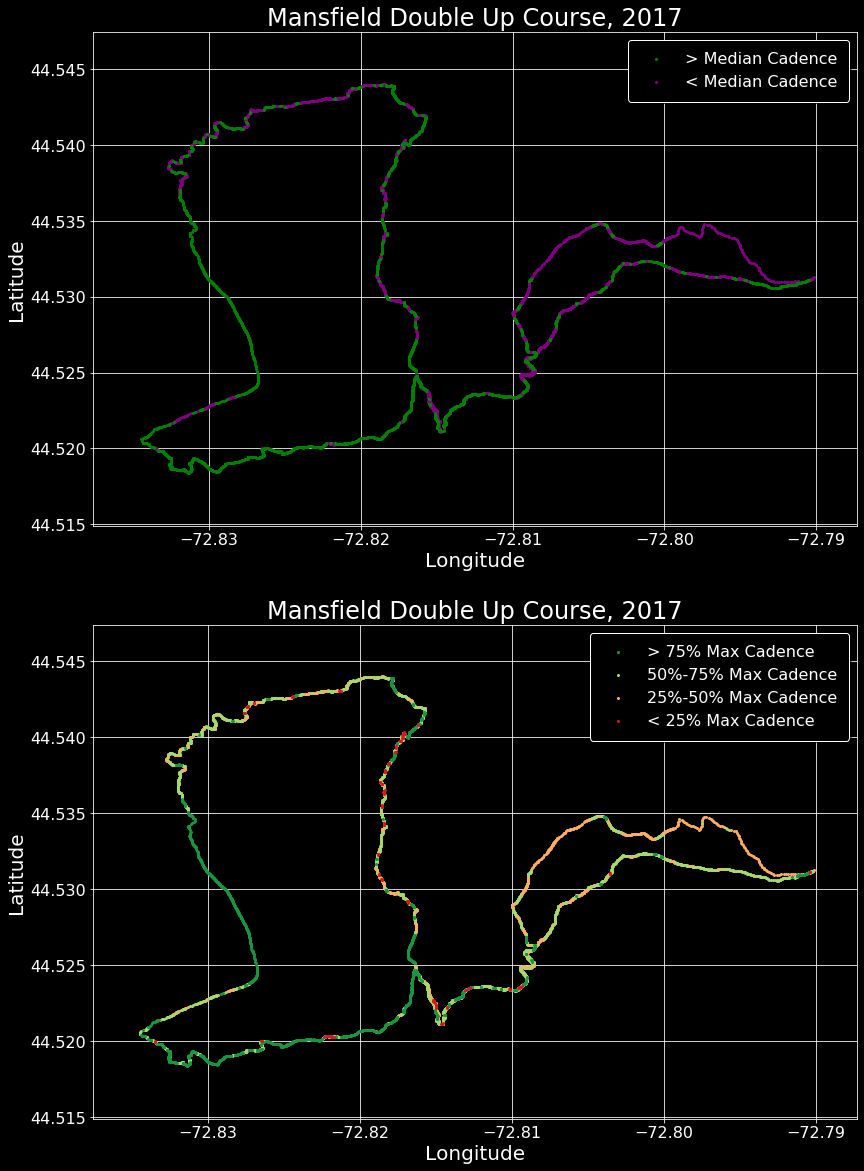

In [19]:
# Plot course lat/lon with cadence
with plt.style.context('dark_background'):  

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))
    double_up_gdf[double_up_gdf.cadence >= double_up_gdf.cadence.median()].plot(
        ax=ax1, markersize=4, color='g', label="> Median Cadence", zorder=3)
    double_up_gdf[double_up_df_enhance.cadence < double_up_df_enhance.cadence.median()].plot(
        ax=ax1, markersize=4, color='purple', label="< Median Cadence", zorder=2)
    
    # PURPLE #7b3294 / GREEN #008837
    
    ax1.legend(borderpad=0.75,
          edgecolor='white',
          fontsize=16,
          shadow=True)
    
    ax1.set_xlabel("Longitude")
    #ax.xaxis.label.set_size(12)
    ax1.set_ylabel("Latitude")
    #ax.yaxis.label.set_size(12)
    ax1.set_title("Mansfield Double Up Course, 2017", size=20)

    ax1.grid(True, zorder=1)

    ax1.xaxis.label.set_size(20)
    ax1.yaxis.label.set_size(20)
    ax1.title.set_size(24)
    ax1.tick_params(labelsize=16)
    
    
    double_up_gdf[double_up_gdf.cadence >= double_up_gdf.cadence.max()*0.75].plot(
        ax=ax2, markersize=4, color='#1a9641', label="> 75% Max Cadence", zorder=5)
    double_up_gdf[(double_up_gdf.cadence < double_up_gdf.cadence.max()*0.75) & (double_up_gdf.cadence >= double_up_gdf.cadence.max()*0.5)].plot(
        ax=ax2, markersize=4, color='#a6d96a', label="50%-75% Max Cadence", zorder=4)
    double_up_gdf[(double_up_gdf.cadence < double_up_gdf.cadence.max()*0.50) & (double_up_gdf.cadence >= double_up_gdf.cadence.max()*0.25)].plot(
        ax=ax2, markersize=4, color='#fdae61', label="25%-50% Max Cadence", zorder=3)
    double_up_gdf[double_up_gdf.cadence < double_up_gdf.cadence.max()*0.25].plot(
        ax=ax2, markersize=4, color='#d7191c', label="< 25% Max Cadence", zorder=6)
       
   # RED ['#d7191c','#fdae61','#a6d96a','#1a9641'] GREEN
    
    ax2.legend(borderpad=0.75,
          edgecolor='white',
          fontsize=16,
          shadow=True)
    
    ax2.set_xlabel("Longitude")
    #ax.xaxis.label.set_size(12)
    ax2.set_ylabel("Latitude")
    #ax.yaxis.label.set_size(12)
    ax2.set_title("Mansfield Double Up Course, 2017", size=20)

    ax2.grid(True, zorder=1)

    ax2.xaxis.label.set_size(20)
    ax2.yaxis.label.set_size(20)
    ax2.title.set_size(24)
    ax2.tick_params(labelsize=16)

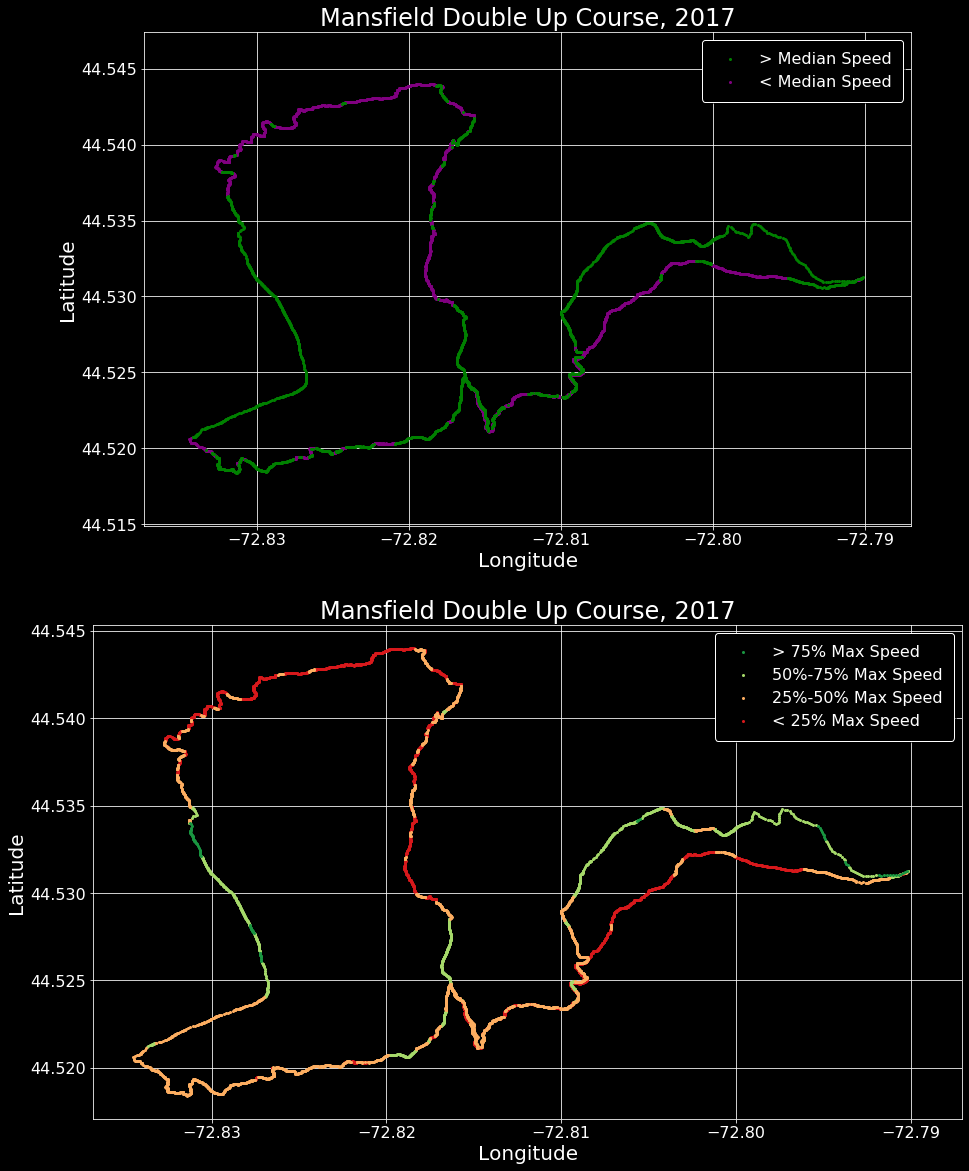

In [20]:
# Plot course lat/lon with speed
with plt.style.context('dark_background'):  

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))
    double_up_gdf[double_up_gdf.speed_mph >= double_up_gdf.speed_mph.median()].plot(
        ax=ax1, markersize=4, color='g', label="> Median Speed", zorder=3)
    double_up_gdf[double_up_gdf.speed_mph < double_up_gdf.speed_mph.median()].plot(
        ax=ax1, markersize=4, color='purple', label="< Median Speed", zorder=2)
    
    
    
    ax1.legend(borderpad=0.75,
          edgecolor='white',
          fontsize=16,
          shadow=True)
    
    ax1.set_xlabel("Longitude")
    #ax.xaxis.label.set_size(12)
    ax1.set_ylabel("Latitude")
    #ax.yaxis.label.set_size(12)
    ax1.set_title("Mansfield Double Up Course, 2017", size=20)

    ax1.grid(True, zorder=1)

    ax1.xaxis.label.set_size(20)
    ax1.yaxis.label.set_size(20)
    ax1.title.set_size(24)
    ax1.tick_params(labelsize=16)
    
    double_up_gdf[double_up_gdf.speed_mph >= double_up_gdf.speed_mph.max()*0.75].plot(
        ax=ax2, markersize=4, color='#1a9641', label="> 75% Max Speed", zorder=5)
    double_up_gdf[(double_up_gdf.speed_mph < double_up_gdf.speed_mph.max()*0.75) & (double_up_gdf.speed_mph >= double_up_gdf.speed_mph.max()*0.5)].plot(
        ax=ax2, markersize=4, color='#a6d96a', label="50%-75% Max Speed", zorder=4)
    double_up_gdf[(double_up_gdf.speed_mph < double_up_gdf.speed_mph.max()*0.50) & (double_up_gdf.speed_mph >= double_up_gdf.speed_mph.max()*0.25)].plot(
        ax=ax2, markersize=4, color='#fdae61', label="25%-50% Max Speed", zorder=4)
    double_up_gdf[double_up_gdf.speed_mph < double_up_gdf.speed_mph.max()*0.25].plot(
        ax=ax2, markersize=4, color='#d7191c', label="< 25% Max Speed", zorder=2)
    
    
    
   # RED ['#d7191c','#fdae61','#a6d96a','#1a9641'] GREEN
    
    ax2.legend(borderpad=0.75,
          edgecolor='white',
          fontsize=16,
          shadow=True)
    
    ax2.set_xlabel("Longitude")
    #ax.xaxis.label.set_size(12)
    ax2.set_ylabel("Latitude")
    #ax.yaxis.label.set_size(12)
    ax2.set_title("Mansfield Double Up Course, 2017", size=20)

    ax2.grid(True, zorder=1)

    ax2.xaxis.label.set_size(20)
    ax2.yaxis.label.set_size(20)
    ax2.title.set_size(24)
    ax2.tick_params(labelsize=16)

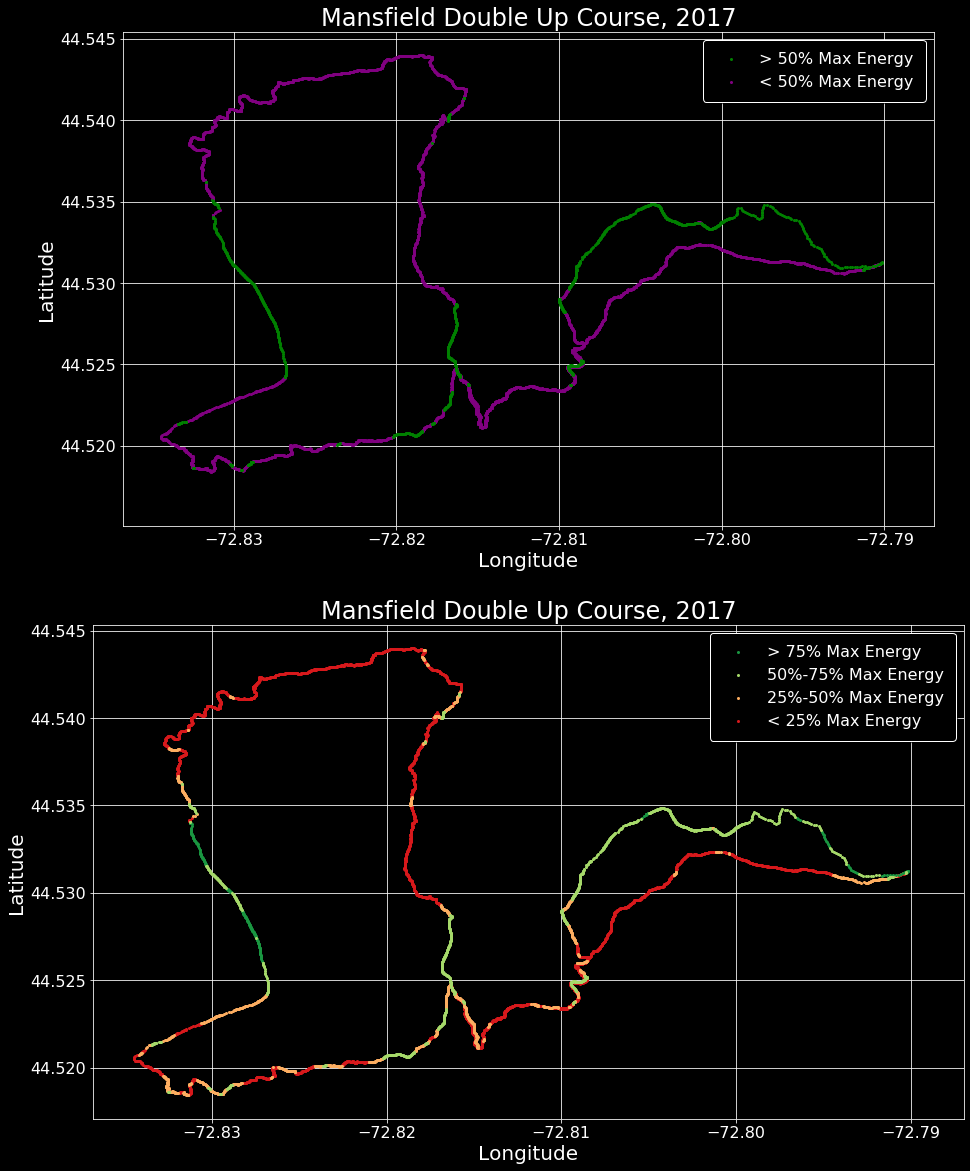

In [21]:
# Plot course lat/lon with normalized energy
with plt.style.context('dark_background'):  

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))
    double_up_gdf[double_up_gdf.energy_norm >= 0.5].plot(
        ax=ax1, markersize=4, color='g', label="> 50% Max Energy", zorder=3)
    double_up_gdf[double_up_gdf.energy_norm < 0.5].plot(
        ax=ax1, markersize=4, color='purple', label="< 50% Max Energy", zorder=2)
    
    
    
    ax1.legend(borderpad=0.75,
          edgecolor='white',
          fontsize=16,
          shadow=True)
    
    ax1.set_xlabel("Longitude")
    #ax.xaxis.label.set_size(12)
    ax1.set_ylabel("Latitude")
    #ax.yaxis.label.set_size(12)
    ax1.set_title("Mansfield Double Up Course, 2017", size=20)

    ax1.grid(True, zorder=1)

    ax1.xaxis.label.set_size(20)
    ax1.yaxis.label.set_size(20)
    ax1.title.set_size(24)
    ax1.tick_params(labelsize=16)
    
    double_up_gdf[double_up_gdf.energy_norm >= 0.75].plot(
        ax=ax2, markersize=4, color='#1a9641', label="> 75% Max Energy", zorder=5)
    double_up_gdf[(double_up_gdf.energy_norm <0.75) & (double_up_gdf.energy_norm >= 0.5)].plot(
        ax=ax2, markersize=4, color='#a6d96a', label="50%-75% Max Energy", zorder=5)
    double_up_gdf[(double_up_gdf.energy_norm <0.5) & (double_up_gdf.energy_norm >= 0.25)].plot(
        ax=ax2, markersize=4, color='#fdae61', label="25%-50% Max Energy", zorder=3)
    double_up_gdf[double_up_gdf.energy_norm <= 0.25].plot(
        ax=ax2, markersize=4, color='#d7191c', label="< 25% Max Energy", zorder=2)
    
    
    # RED ['#d7191c','#fdae61','#a6d96a','#1a9641'] GREEN
    
    
    ax2.legend(borderpad=0.75,
          edgecolor='white',
          fontsize=16,
          shadow=True)
    
    ax2.set_xlabel("Longitude")
    #ax.xaxis.label.set_size(12)
    ax2.set_ylabel("Latitude")
    #ax.yaxis.label.set_size(12)
    ax2.set_title("Mansfield Double Up Course, 2017", size=20)

    ax2.grid(True, zorder=1)

    ax2.xaxis.label.set_size(20)
    ax2.yaxis.label.set_size(20)
    ax2.title.set_size(24)
    ax2.tick_params(labelsize=16)
    
    plt.show()

### 5.7 Upload Course to ArcGIS Online

In [22]:
# module_list = ['pandas', 'geopandas']
# for module in module_list:
#     try:
#         import module
#     except ModuleNotFoundError as error:
#         print(f"ERROR: {error}. Installing module now...")


## 6.0 Risk Assessment

No data was altered (omitted, etc)

## 7.0 Conclusion

## References